# Intro

This notebook is used to 

1. Train classifiers to predict used wall time, and then 

2. Save the trained model along with the data it used. 

This includes a decision tree, a random forest, a gradient boosted decision tree model, and a logistic regressor.

Fully and carefully evaluating the models should be done in test-model.ipynb, but there are some functions here to give a quick idea of whether the models are worth saving.

# Notebook options

There are 4 options for each model:

1. 'train_model': Whether the notebook will train this type of model at all. If False, all other options can be ignored.

2. 'grid_search': Whether the notebook will execute a grid search to find the best combination of hyperparameters. If False, the notebook will just use some pre-set parameters (which were found in previous grid searches).

3. 'training_mode': Either 'normal', 'test', or 'final'. Data is always split 50-25-25 into training, validation, and test sets. Models are always trained on the training set to begin with. This option indicates whether the model will train on the training data only ('normal' mode), the training data and the validation data ('test' mode), or all three datasets ('final' mode). Note that any extra training data (from validation/test sets) is only introduced at the very end, after the scaling of the X values, and after the grid search.

4. 'save_model': Whether the model will be saved after fitting to the data. 

The random forest model has a fifth option:

5. 'n_jobs': How many jobs to run in parallel for training. Only used during the grid search (otherwise this setting would persist when the model is saved). 

In [26]:
options = {'tree':   {'train_model': False,
                      'grid_search': True,
                      'training_mode': 'normal',
                      'save_model': False},
           'forest': {'train_model': True,
                      'grid_search': True,
                      'training_mode': 'final',
                      'save_model': True,
                      'n_jobs': 1},
           'gboost': {'train_model': False,
                      'grid_search': False,
                      'training_mode': 'final',
                      'save_model': False},
           'logist': {'train_model': True,
                      'grid_search': True,
                      'training_mode': 'normal',
                      'save_model': False}
          }

tree_options = options['tree']
forest_options = options['forest']
gboost_options = options['gboost']
logist_options = options['logist']

# Imports

In [2]:
import pandas as pd
import numpy as np
import math
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, \
                             GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from hypopt import GridSearch
from preprocessing import get_df, scale, make_category_col
from evaluation import score_model, \
                       print_feature_importances, \
                       plot_cm, \
                       print_cr, \
                       auc
from persistence import model_saver

/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/hypopt/model_selection.py:39: UserWarning: If you want to see estimated completion times
    while running methods in cleanlab.pruning, install tqdm
    via "pip install tqdm".
  warnings.warn(w)


# Preprocessing

## General

Much of the general preprocessing work (used for both memory and time models) is handled in preprocessing.py. This includes adding composite features and handling missing values.

In [3]:
df = get_df()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   rinfo            50360 non-null  object             
 1   request_type     50360 non-null  object             
 2   job_start_at     50360 non-null  datetime64[ns]     
 3   job_end_at       50360 non-null  datetime64[ns]     
 4   req_mem          50360 non-null  float64            
 5   used_mem         50360 non-null  float64            
 6   dsnum            48150 non-null  object             
 7   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 8   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 9   dates_init       50360 non-null  bool               
 10  slat             32123 non-null  float64            
 11  nlat             32123 non-null  float64            
 12  wlon             32140 non-null  float64            
 13  elon    

## Categorization

The coming blocks add a 'mem_category' column to the dataframe based on the categories we input in the next cell. The function make_category_col comes from preprocessing.py.

The dictionary categories_dict holds the upper bound for each category of memory in megabytes.

In [4]:
categories_dict = {0:60, 1:120, 2:300, 
                   3:600, 4:1800, 5:3600,
                   6:14400, 7:43200}

num_classes = len(categories_dict)

In [5]:
df = make_category_col(df, 'time', categories_dict)

In [6]:
def replace_null_category(row):
    val = row['time_category']
    if not pd.isnull(val):
        return int(val)
    else:
        return num_classes - 1 #highest category
    
df['time_category'] = df.apply(lambda row: replace_null_category(row),
                               axis=1)

The next cell is here to confirm that the categories were calculated correctly.

In [7]:
df[['wall_time', 'time_category']].sample(10)

,wall_time,time_category
6407272,417.0,3
6409783,88.0,1
6453074,70.0,1
6516356,416.0,3
6495926,148.0,2
6420464,91.0,1
6517567,45.0,0
6244521,1106.0,4
6444547,627.0,4
6728211,45.0,0


The next cell shows how many entries occupy each category.

In [8]:
def print_category_counts():
    bin_sizes = np.bincount(df['time_category'])
    print(f"0: < {categories_dict[0]}MB ({bin_sizes[0]} entries)")
    for i in range(1, num_classes):
        print(f"{i}: >= {categories_dict[i-1]}MB"
              + f" and < {categories_dict[i]}MB"
              + f" ({bin_sizes[i]} entries)")
        
print_category_counts()

0: < 60MB (7371 entries)
1: >= 60MB and < 120MB (10720 entries)
2: >= 120MB and < 300MB (8174 entries)
3: >= 300MB and < 600MB (5519 entries)
4: >= 600MB and < 1800MB (7726 entries)
5: >= 1800MB and < 3600MB (4005 entries)
6: >= 3600MB and < 14400MB (5521 entries)
7: >= 14400MB and < 43200MB (1324 entries)


## Feature selection

All columns in X_features will be used to make predictions. 

Note that we only want to predict one of the columns in y_features (namely time_category), but we keep the related information wall_time there for future testing.

In [9]:
X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
y_features = ['wall_time', 'time_category']

X = df[X_features]
y = df[y_features]

## Train/validation/test split

We split the data into training, validation, and testing sets according to the proportions in the next cell.

In [10]:
train_amt = 0.5
val_amt = 0.25
test_amt = 0.25

In [11]:
X_train, X_target, y_train_full, y_target_full = \
                train_test_split(X, y, 
                test_size=1-train_amt, 
                random_state = 3)
X_val, X_test, y_val_full, y_test_full = \
                train_test_split(X_target, y_target_full,
                                 test_size = test_amt/train_amt,
                                 random_state = 3)

In [12]:
y_train = np.ravel(y_train_full['time_category'])
y_val = np.ravel(y_val_full['time_category'])
y_test = np.ravel(y_test_full['time_category'])

## Scaling

The scaling function is from preprocessing.py -- it scales the training, validation, and test input data according to the statistics of the training set only. (This is to prevent data leakage.)

In [13]:
X_train_norm, X_val_norm, X_test_norm = \
    scale(X_train, X_val, X_test)

The data sets at our disposal now are:

X_train, X_val, X_test: unscaled input data

X_train_norm, X_val_norm, X_test_norm: scaled input data

y_train, y_val, y_test: only the output data we want to predict

y_train_full, y_val_full, y_test_full: the output data plus some additional info

# Training

The next two cells create scorer objects (sklearn.metrics._scorer._PredictScorer) which are used during grid searches.

The scorer created in this cell, balanced_scorer, replicates how the models automatically score themselves on the training set when class_weight='balanced' is passed as a parameter.

In [14]:
def balanced_score(y, y_pred, **kwargs):
    n_samples = X_train.shape[0]
    class_weights = n_samples / (num_classes * (np.bincount(y_train)))

    score = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            score += class_weights[y[i]]
        
    return score

balanced_scorer = make_scorer(score_func=balanced_score,
                              greater_is_better=True)

## Trees and ensembles of trees

### Tree

In [15]:
if tree_options['train_model'] and tree_options['grid_search']:
    start = time.time()
    tree_param_grid = {'random_state':[3], 
                       'max_depth':range(2,15),
                       'min_samples_split':range(2,10),
                       'class_weight':['balanced']}
    tree_gs = GridSearch(model=DecisionTreeClassifier(), 
                              param_grid=tree_param_grid,
                              parallelize=False)
    tree_gs.fit(X_train_norm, y_train, 
                X_val_norm, y_val, 
                scoring=balanced_scorer)
    
    print(tree_gs.best_params)
    tree = tree_gs.best_estimator_
    
    end = time.time()
    print(f"Time = {end-start}")

elif tree_options['train_model']:
    tree = DecisionTreeClassifier(class_weight='balanced',
                                  max_depth=14,
                                  min_samples_split=2,
                                  random_state=3)
    tree.fit(X_train_norm, y_train)
else:
    tree = DecisionTreeClassifier()

### Forest

In [16]:
if forest_options['train_model'] and forest_options['grid_search']:
    start = time.time()
    forest_param_grid = {'random_state':[3],
                         'max_depth':range(2,20),
                         'min_samples_split':range(5,35,5),
                         'n_estimators':range(50,250,25),
                         'n_jobs':[forest_options['n_jobs']],
                         'class_weight':['balanced']}
    forest_gs = GridSearch(model=RandomForestClassifier(), 
                                param_grid=forest_param_grid,
                                parallelize=False)
    forest_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    end = time.time()
    print(f"Time = {end-start}")
    print(forest_gs.best_params)
    forest = forest_gs.best_estimator_
elif forest_options['train_model']:
    forest = RandomForestClassifier(class_weight='balanced',
                                      max_depth=18,
                                      min_samples_split=5,
                                      n_estimators=175,
                                      random_state=3)
    forest.fit(X_train_norm, y_train)
else:
    forest = RandomForestClassifier()

Time = 1557.5997319221497
{'class_weight': 'balanced', 'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 175, 'n_jobs': 1, 'random_state': 3}


Scikit-learn currently has no class_weight parameter for GradientBoostingClassifier, so we use the default scoring metric in training and in the grid search.

In [17]:
if gboost_options['train_model'] and gboost_options['grid_search']:
    start = time.time()
    gboost_param_grid = {'random_state':[3],
                         'max_depth':range(2,20),
                         'n_estimators':range(50,300,50)}
    gboost_gs = GridSearch(model=GradientBoostingClassifier(), 
                                param_grid=gboost_param_grid,
                                parallelize=False)
    gboost_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    
    print(gboost_gs.best_params)
    gboost = gboost_gs.best_estimator_
    
    end = time.time()
    print(f"Time = {end-start}")
elif gboost_options['train_model']:
    gboost = GradientBoostingClassifier(random_state=3,
                                        max_depth=14,
                                        n_estimators=150)
    gboost.fit(X_train_norm, y_train)
else:
    gboost = GradientBoostingClassifier()

## Logistic Regression

In [18]:
if logist_options['train_model'] and logist_options['grid_search']:
    start = time.time()
    logist_param_grid = {'penalty':['l1', 'l2', 'none'],
                         'C':[0.1, 1, 10],
                         'max_iter':[200],
                         'class_weight':['balanced'],
                         'solver':['saga']}
    logist_gs = GridSearch(model=LogisticRegression(), 
                                param_grid=logist_param_grid,
                                parallelize=False)
    logist_gs.fit(X_train_norm, y_train, 
                  X_val_norm, y_val,
                  scoring=balanced_scorer)
    
    print(logist_gs.best_params)
    logist = logist_gs.best_estimator_
    
    end = time.time()
    print(f"Time = {end-start}")

elif logist_options['train_model']:
    logist = LogisticRegression(max_iter=200,
                                class_weight='balanced',
                                penalty='l1',
                                solver='saga',
                                C=0.1)
    logist.fit(X_train_norm, y_train)
else:
    logist = LogisticRegression()

/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/glade/u/home/jdubeau/github/rd

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Time = 29.29653263092041


/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


# Extra training

This section trains the models on extra data if their training_mode option is set to either 'test' or 'final'.

In [27]:
models_dict = {'tree': tree,
               'forest': forest,
               'gboost': gboost,
               'logist': logist}

In [28]:
test_mode_X_train_norm = np.concatenate((X_train_norm, X_val_norm))
test_mode_y_train = np.ravel(pd.concat([y_train_full,
                                  y_val_full])['time_category'])

final_mode_X_train_norm = np.concatenate((X_train_norm,
                              X_val_norm,
                              X_test_norm))
final_mode_y_train = np.ravel(pd.concat([y_train_full,
                                  y_val_full,
                                  y_test_full])['time_category'])

In [29]:
for model_name in models_dict:
    if options[model_name]['train_model']:
        if options[model_name]['training_mode'] == 'test':
            models_dict[model_name].fit(test_mode_X_train_norm,
                                        test_mode_y_train)
        elif options[model_name]['training_mode'] == 'final':
            models_dict[model_name].fit(final_mode_X_train_norm,
                                        final_mode_y_train)

# Evaluation

Here we make some simple graphs and reports to give an idea whether our models are worth saving. Note that all figures and reports are done using the validation data -- if the models are set to 'test' or 'final' training modes, they will have already trained on this data!

<Figure size 432x288 with 0 Axes>

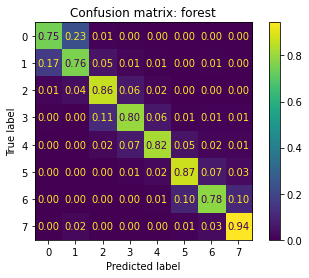

<Figure size 432x288 with 0 Axes>

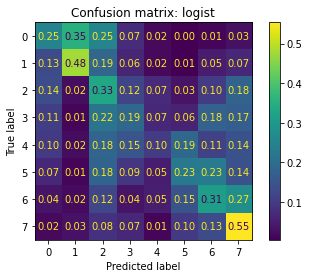

In [30]:
for model_name in models_dict:
    if options[model_name]['train_model']:
        plot_cm(X_val=X_val_norm, y_val=y_val,
                model_name=model_name, 
                model=models_dict[model_name])

In [31]:
for model_name in models_dict:
    if options[model_name]['train_model']:
        print(f"Classification report: {model_name}")
        print_cr(X_val_norm, y_val, models_dict[model_name])

Classification report: forest
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1817
           1       0.79      0.76      0.77      2590
           2       0.84      0.86      0.85      2088
           3       0.78      0.80      0.79      1428
           4       0.90      0.82      0.86      1964
           5       0.77      0.87      0.82       963
           6       0.88      0.78      0.83      1404
           7       0.58      0.94      0.72       336

    accuracy                           0.80     12590
   macro avg       0.79      0.82      0.80     12590
weighted avg       0.81      0.80      0.81     12590

Classification report: logist
              precision    recall  f1-score   support

           0       0.29      0.25      0.27      1817
           1       0.60      0.48      0.53      2590
           2       0.26      0.33      0.29      2088
           3       0.21      0.19      0.20      1428
           4      

# Persistence

This section saves the models using the model_saver object from persistence.py. We begin by creating a 'notes' string for each model we intend to save, which by default just specifies which notebook options were used for that model.

In [32]:
full_model_names = {'tree': 'Decision Tree Classifier',
                    'forest': 'Random Forest Classifier',
                    'gboost': 'Gradient Boosting Classifier',
                    'logist': 'Logistic Regression'}

training_data_names = {'normal': 'training',
                       'test': 'training and validation',
                       'final': 'training, validation, and testing'}

model_notes = {}

for model_name in models_dict:
    if options[model_name]['train_model'] and options[model_name]['save_model']:
        data_name = training_data_names[options[model_name]['training_mode']]
        grid_search = options[model_name]['grid_search']
        notes = f"{full_model_names[model_name]}. " \
                 + f"Trained on {data_name} data. " \
                 + f"Grid search {'not ' if not grid_search else ''}performed. " \
                 + "X values NOT scaled."
        model_notes[model_name] = notes
        
print(model_notes)

{'forest': 'Random Forest Classifier. Trained on training, validation, and testing data. Grid search performed. X values NOT scaled.'}


Now we save all the desired models. Note that by passing folder_path=None as a parameter to the model_saver object, models will be saved at the default path found in persistence.py, that is, /glade/work/jdubeau/model-saves/.

This creates a folder for each model, e.g. /glade/work/jdubeau/model-saves/time_class_forest_test2021-07-01-16:04/

In [33]:
for model_name in models_dict:
    if options[model_name]['train_model'] and options[model_name]['save_model']:
        save_name = 'time_class_' \
                    + model_name \
                    + '_' \
                    + options[model_name]['training_mode']
        ms = model_saver(save_name, 
                         model_notes[model_name],
                         models_dict[model_name], 
                         df, 
                         categories_dict,
                         X_features,
                         X_train, y_train_full,
                         X_val, y_val_full,
                         X_test, y_test_full,
                         folder_path=None)
        ms.save()